<a href="https://colab.research.google.com/github/wrightky/ANUGA_DXWorkshop/blob/main/WLAD_Model/WLAD_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<div align="center">**Wax Lake & Atchafalaya Delta Model**</div>
##<div align="center">ANUGA Tutorial</div>
##<div align="center">Kyle Wright</div>
###<div align="center">Delta-X Applications Workshop (May 5th, 2022)</div>

## Information on this session:

**Goal:** Introduce the basics of the hydrodynamic model for the Wax Lake & Atchafalaya Delta (WLAD) basin using ANUGA. This model solves the 2D shallow-water equations on an unstructured triangular grid. Note that the model structure has been slightly simplified for parts of this demonstration.

**Software:** ANUGA, Python, Jupyter Notebooks, other packages

**Installation:** None, this lab is run on the cloud in the Google `colaboratory` environment.

**Details:** In this tutorial, we will build, run, and analyze our model of the actively-aggrading WLAD basin. This is one of the two Delta-X study sites, and we will be simulating the period that aligns with the Spring 2021 campaign. Different cell blocks will demonstate how one can build the model mesh, initialize the domain, setup the parameters of the model, and run the simulation. 

The regular version of this model is written as a collection of Python scripts that are run in parallel on a high-performance computing cluster (e.g. [TACC](https://www.tacc.utexas.edu/)). However, we have simplified the model here to allow it to run in this notebook on Google Colab, so that we can demonstrate the workflow of the model, which is identical to that in the true version. The raw codes for the current parallel implementation have been included in this repository along with this notebook, so feel free to glance through those as well. 

This notebook is written in Python 3, and has been designed to run in the Google `colaboratory` environment, which provides a Jupyter notebook environment running on a virtual machine on the cloud. Nothing needs to be installed locally, as it is entirely run on Google Drive. All you need is a Google account. All of these scripts are stored on GitHub.

To start interacting with the notebook, make sure it is open in Colab (see `Open in Colab` link above). Once you're there, click `File` > `Save a Copy in Drive`.

## Setup Environment

The first thing we have to do is set up our environment. In Python, this means downloading all the necessary functions we want to use, including ANUGA.

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory. The install should take less than a minute.

*Pro-tip: To run each code block, you can simply type `shift` + `enter`*

NOTE: Tutorial installation is based on the [2018 CSDMS Anuga Clinic](https://github.com/stoiver/anuga-clinic-2018), but updated to work in Python 3.

In [1]:
!rm -r ANUGA_DXWorkshop

In [2]:
# Here we download/install all the files we need behind the scenes
try:
    import os
    os.chdir('/content')
    # Grab workbook files into colab directory
    !git clone https://github.com/wrightky/ANUGA_DXWorkshop.git
    # Install everything using some bash scripts
    !/bin/bash /content/ANUGA_DXWorkshop/anuga_tools/install_anuga_colab.sh
    !python /content/ANUGA_DXWorkshop/anuga_tools/install.py > /dev/null 2>&1 
except:
    pass

# Deal with some directory stuff
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
import sys
sys.path.append(os.path.join(workbookDir,"ANUGA_DXWorkshop"))
sys.path.append(os.path.join(workbookDir,"anuga_core"))

Cloning into 'ANUGA_DXWorkshop'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 260 (delta 31), reused 246 (delta 21), pack-reused 0
Receiving objects: 100% (260/260), 2.24 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (31/31), done.


## Import packages

Now that everything is installed, we can load the packages we want to use directly into this notebook. Most of these are very common packages, and each one contains a different group of functions that are useful for scientific applications. We access these functions by 'importing' the packages we need. See the comments below for a brief discription of what each of these packages are for.

In [3]:
import numpy as np # Array manipulation, most important Python package
import matplotlib # Plotting/visualization
import matplotlib.pyplot as plt # Convenient shorthand for the main plotting function
matplotlib.use('Agg') # Settings
%matplotlib inline
from scipy.interpolate import interp1d # Simple linear interpolation
import pandas as pd # Spreadsheets/excel data
import os # Operating system, handles directories
import glob # Also for files
# from PIL import Image # For making output animations
import anuga # The model itself
from anuga.utilities import animate # Built-in plotting tool for the model
from anuga import Inlet_operator # Explained later

In [6]:
from ANUGA_DXWorkshop.WLAD_Model.settings import *
from ANUGA_DXWorkshop.WLAD_Model.tools import *
os.chdir('ANUGA_DXWorkshop/WLAD_Model')

Default false northing is 10000000.000000.
ANUGA does not correct for differences in False Northings.
Figure files for each frame will be stored in _plot


(624040.222045, 680256.343655, 3220663.3324, 3302688.5856)

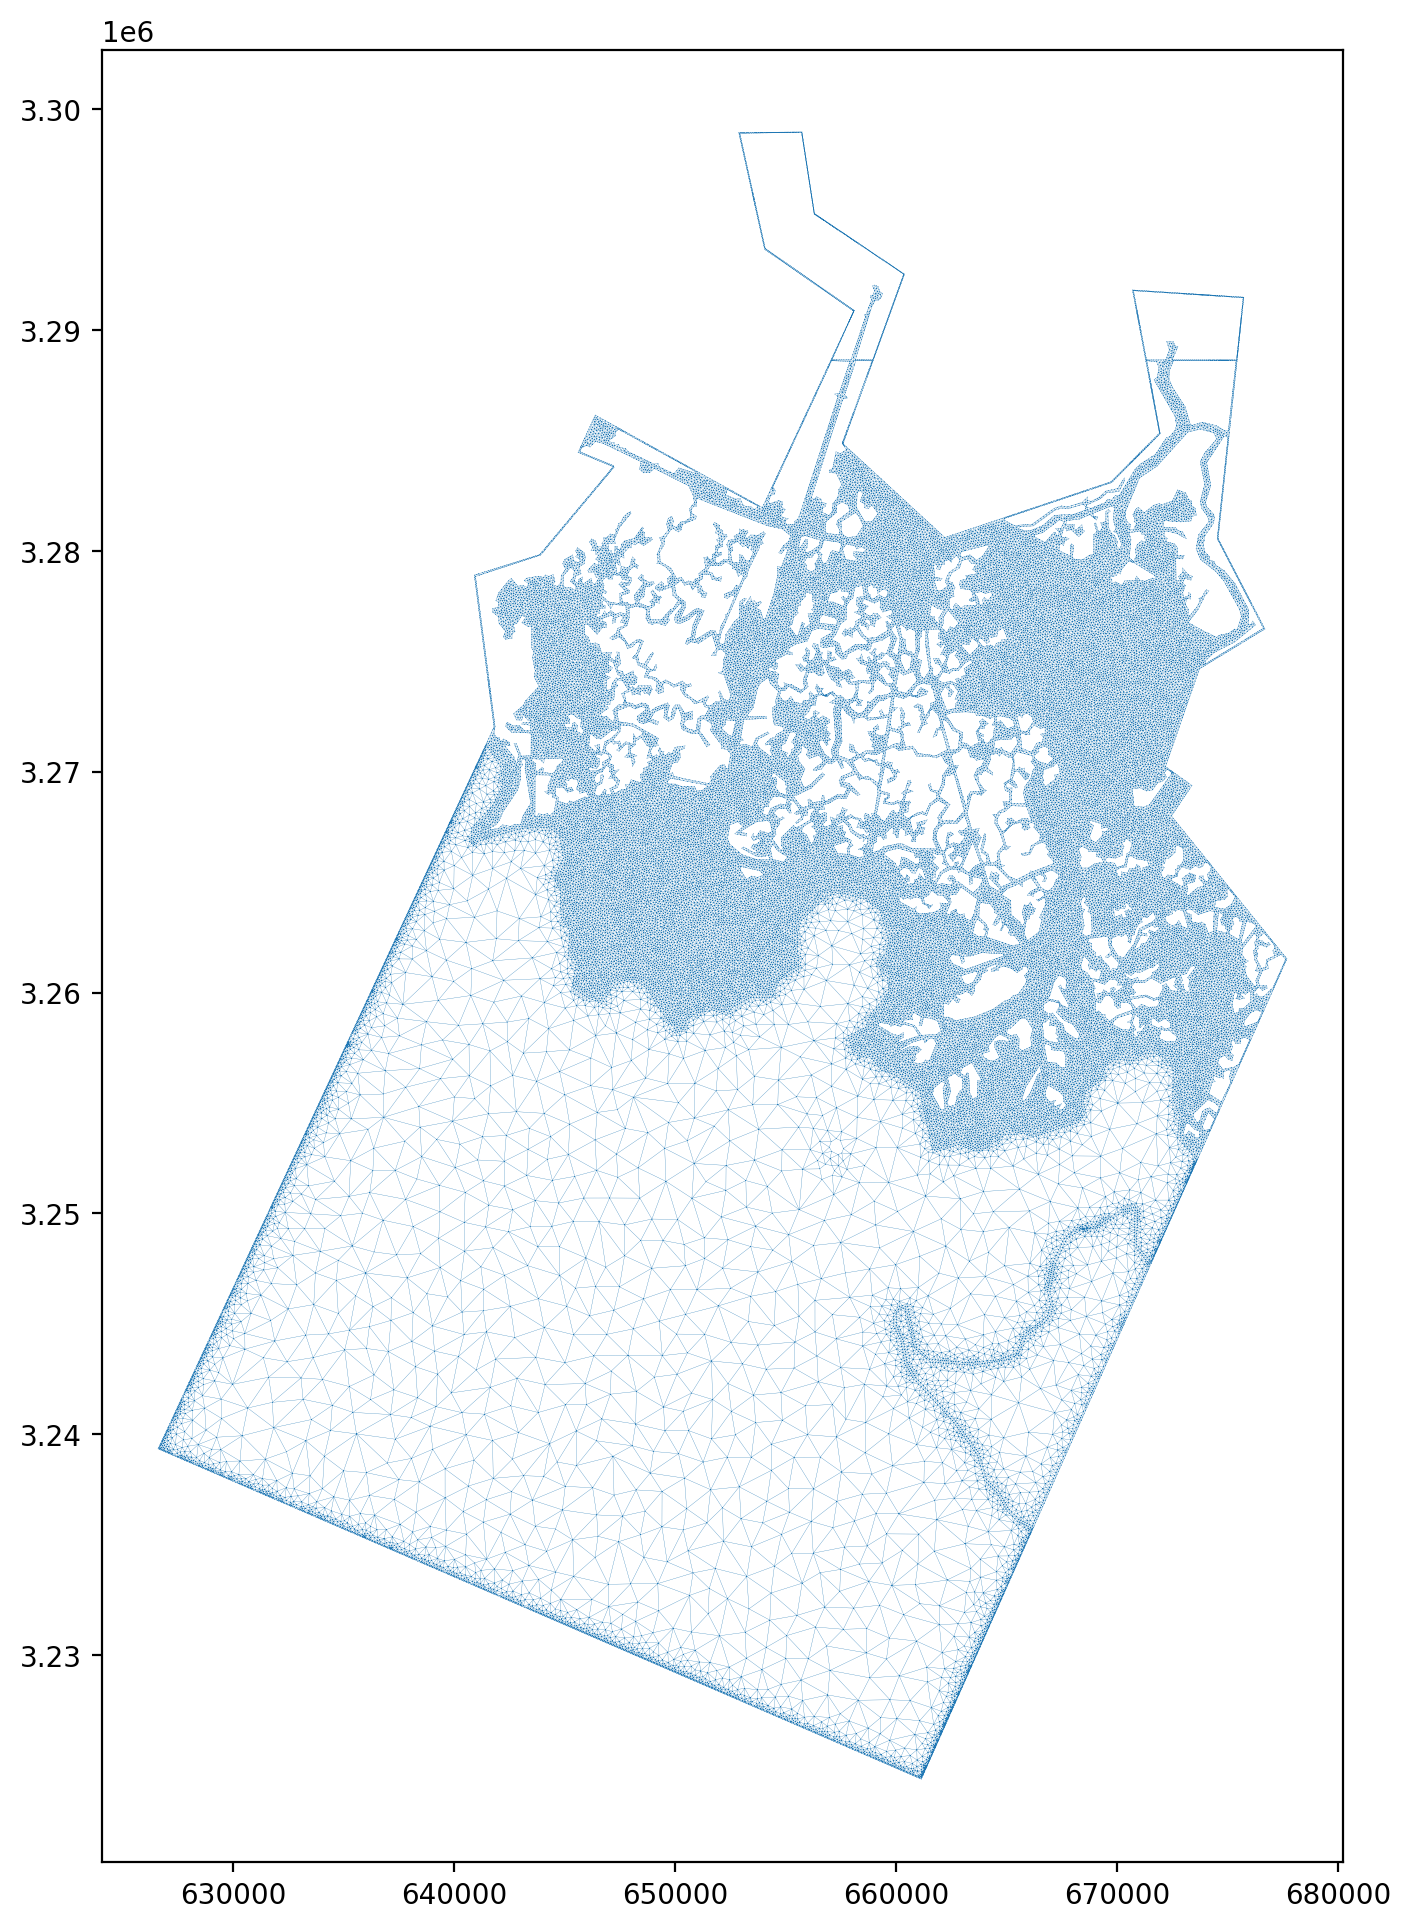

In [9]:
bounding_polygon, boundary_tags, inside_regions, geo_reference = GenerateDomainGeometry()

inside_holes = [i[0] for i in inside_regions if i[1]==62500]
inside_regions = [i for i in inside_regions if i[1]>62500]

domain = anuga.create_domain_from_regions(bounding_polygon, boundary_tags,
                                          maximum_triangle_area=10000,
                                          interior_regions=inside_regions,
                                          interior_holes=inside_holes,
                                          poly_geo_reference=geo_reference,
                                          mesh_geo_reference=geo_reference,
                                          mesh_filename = 'WLAD2.msh')

fig = plt.figure(figsize=(10, 12), dpi=200, facecolor='w', edgecolor='k')
dplotter = animate.Domain_plotter(domain)
plt.triplot(dplotter.triang, linewidth=0.1);
plt.axis('scaled')

print(domain.statistics())

In [8]:
print(domain.statistics())

------------------------------------------------
Mesh statistics:
  Number of triangles = 101595
  Extent [m]:
    x in [6.26596e+05, 6.77701e+05]
    y in [3.22439e+06, 3.29896e+06]
  Areas [m^2]:
    A in [1.41467e+02, 9.99696e+05]
    number of distinct areas: 101595
    Histogram:
      [1.41467e+02, 1.00097e+05[: 99447
      [1.00097e+05, 2.00052e+05[: 506
      [2.00052e+05, 3.00008e+05[: 234
      [3.00008e+05, 3.99963e+05[: 152
      [3.99963e+05, 4.99919e+05[: 278
      [4.99919e+05, 5.99874e+05[: 353
      [5.99874e+05, 6.99830e+05[: 248
      [6.99830e+05, 7.99785e+05[: 179
      [7.99785e+05, 8.99741e+05[: 124
      [8.99741e+05, 9.99696e+05]: 74
    Percentiles (10 percent):
      10159 triangles in [1.41467e+02, 4.21407e+03]
      10159 triangles in [4.21407e+03, 4.87768e+03]
      10159 triangles in [4.87768e+03, 5.32587e+03]
      10159 triangles in [5.32587e+03, 5.76875e+03]
      10159 triangles in [5.76875e+03, 6.23415e+03]
      10159 triangles in [6.23415e+03, 6.77

In [10]:
topography_source = r'BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.asc'
# Convert from ASCII to DEM
anuga.asc2dem(topography_source, use_cache=False, verbose=True)
# Convert from DEM to PTS
anuga.dem2pts(topography_source.replace('.asc','.dem'),
              use_cache=False, verbose=True)

domain.set_quantity('elevation', 
                    filename=topography_source.replace('.asc','.pts'),
                    use_cache=False,
                    verbose=True,
                    alpha=0.1)

topo = domain.quantities['elevation'].centroid_values
# Save to disk
np.savetxt(r'BathymetryPolygons/WLAD_topo.csv', topo, delimiter=",")


Reading METADATA from BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.prj
Reading DEM from BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.asc
Got 8134 lines
Store to NetCDF file BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.dem
Reading DEM from BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.dem
Store to NetCDF file BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.pts
There are 52693824 values in the elevation
There are 52693824 values in the clipped elevation
There are 24015675 NODATA_values in the clipped elevation
FitInterpolate: Building quad tree
Building smoothing matrix
Fit.fit: Initializing
Geospatial_data: Created from file: BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.pts
Data will be loaded blockwise on demand
Got 1 variables: ['elevation']
Default false northing is 10000000.000000.
ANUGA does not correct for differences in False Northings.
Default units is m.
ANUGA does not correct for differences in units.
Geospatial_data: Reading 28678149 points (in 29 block(s)) from file 

(624040.222045, 680256.3436550001, 3220663.3324, 3302688.5856000003)

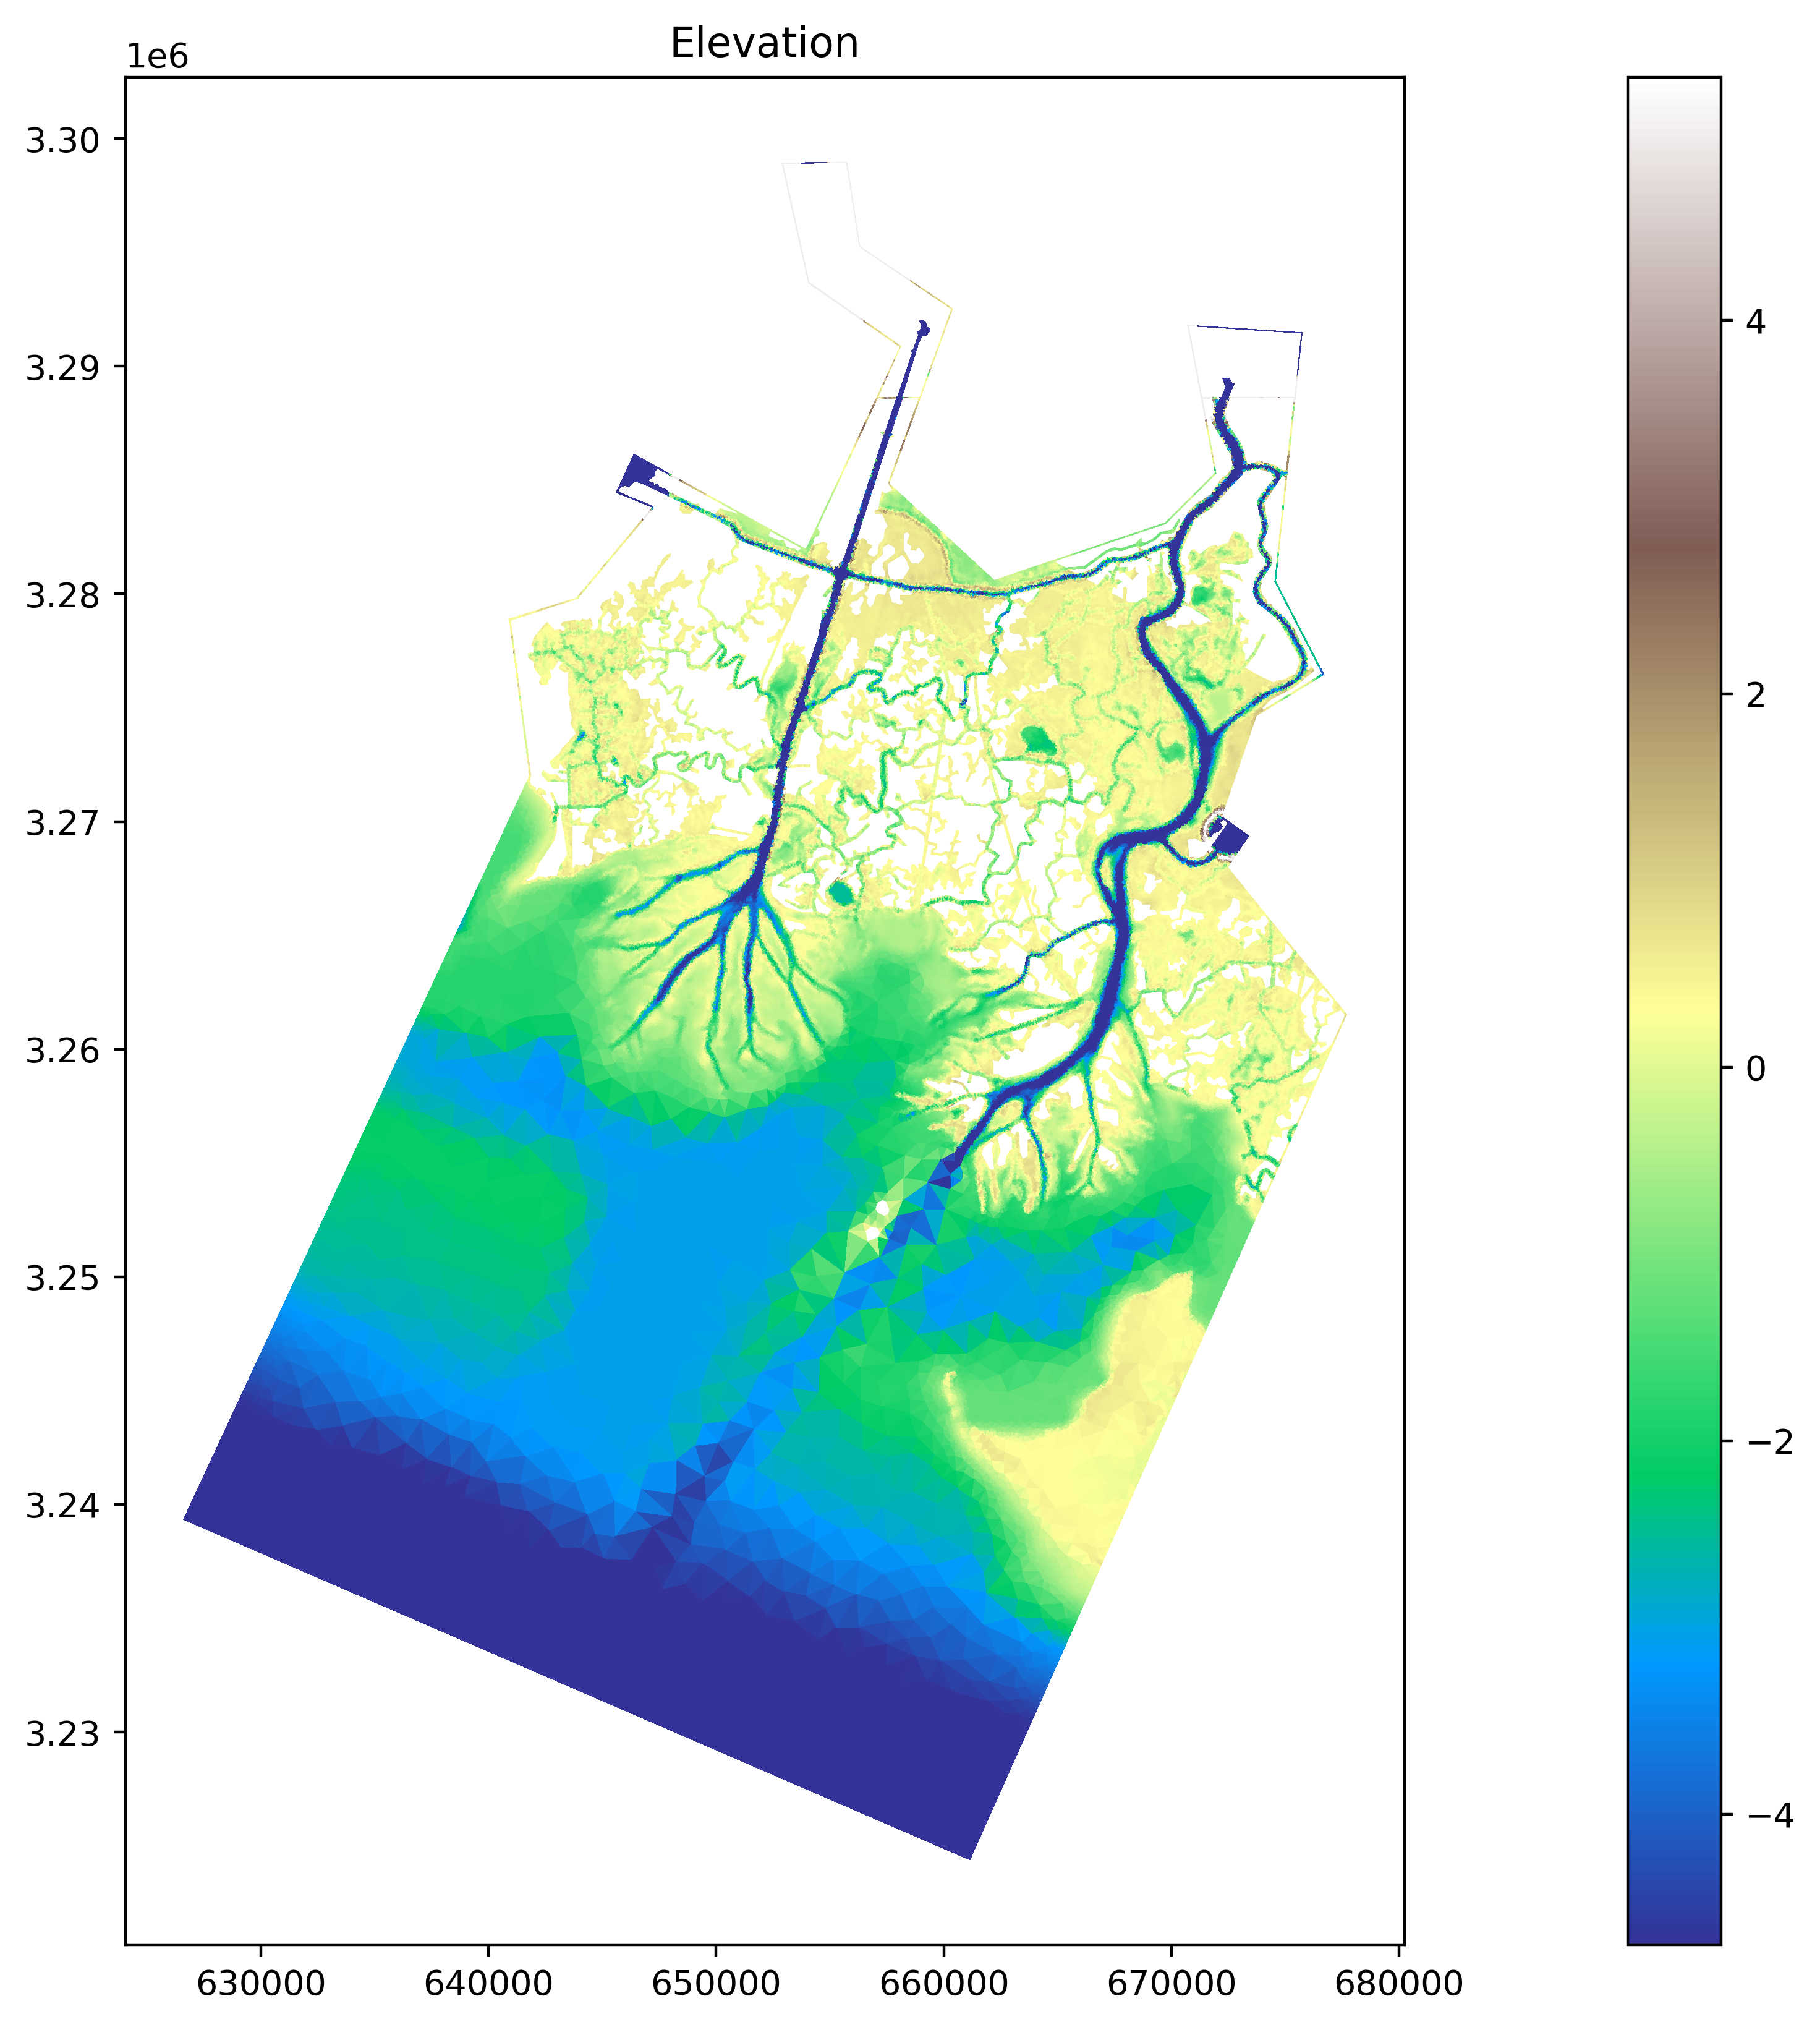

In [11]:
msl = 0.3
fig = plt.figure(figsize=(10, 10), dpi=400, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=dplotter.elev,
              vmax=msl+5, vmin=msl-5, cmap='terrain')
plt.colorbar();
plt.title("Elevation");
plt.axis('scaled')

In [ ]:
fBC_tides = GenerateTideGauge()

In [ ]:
fQ_WLO = GenerateHydrograph(name_WLO) # Calumet inlet
fQ_ATC = GenerateHydrograph(name_ATC) # Morgan City inlet
fQ_FRA = GenerateHydrograph(name_FRA) # Franklin outlet
# Avoca outlet discharge constant and set by Q_AVO

In [ ]:
# Setup inlets
inlet_WLO = Inlet_operator(domain, Q_WLO_loc, Q = fQ_WLO)
inlet_ATC = Inlet_operator(domain, Q_ATC_loc, Q = fQ_ATC)
outlet_FRA = Inlet_operator(domain, Q_FRA_loc, Q = fQ_FRA)
outlet_AVO = Inlet_operator(domain, Q_AVO_loc, Q = Q_AVO)

In [ ]:
# ---------------Load pre-established elevation----------------------
topo = np.loadtxt(topography_source.replace('.asc','.csv'), delimiter=",")

stage = topo.copy()  # Initialize stage as = topography

if not T_steady:
    stage[topo <= fBC_tides(0)] = fBC_tides(0) # Used for cold start
else:
    stage[topo <= steady_T_elev] = steady_T_elev

domain.set_quantity('elevation', topo, location='centroids') 
domain.set_quantity('stage', stage, location='centroids')  # Initialize depth


In [ ]:
x = domain.quantities['x'].centroid_values
y = domain.quantities['y'].centroid_values
FricVal = Raster2Mesh(x, y) # Interpolate from raster onto grid
n, m, hv, D = AssignFricValue(FricVal) # Assign to each cell

# Assign Mannings
domain.set_quantity('friction', n, location = 'centroids')
# Assign Baptist
bapt_op = Baptist_operator(domain,
                           veg_diameter=D,
                           veg_density=m,
                           veg_height=hv,
                           use_diffusivity=False)

In [ ]:
if T_steady:
    Bout = anuga.Dirichlet_boundary([steady_T_elev, 0.0, 0.0]) # Constant (No Tides)
else:
    Bout = anuga.Time_boundary(domain, function = lambda t: [fBC_tides(t), 0.0, 0.0])
Br = anuga.Reflective_boundary(domain)  # Solid walls

domain.set_boundary({'bay': Bout, 'sides': Br})

In [12]:
!zip -r topo.zip BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.pts 

  adding: BathymetryPolygons/WLAD_Bathy_TACC_Carved-ndwi.pts (deflated 73%)
